#Project Setup

In [1]:
!pip -q install transformers datasets torch scikit-learn tqdm sentence-transformers

In [2]:
import pandas as pd

# Helpers

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

def evaluate_model(y, y_pred, data_set_name = ""):
  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  roc_auc = roc_auc_score(y, y_pred)
  conf_matrix = confusion_matrix(y, y_pred, normalize="true")
  log_loss_value = log_loss(y, y_pred)

  print(f"{data_set_name} Accuracy:", accuracy)
  print(f"{data_set_name} Precision:", precision)
  print(f"{data_set_name} Recall:", recall)
  print(f"{data_set_name} F1 Score:", f1)
  print(f"{data_set_name} ROC AUC Score:", roc_auc)
  print("="*10)
  print("Main Metric")
  print("="*10)
  print(f"{data_set_name} Cross Entropy Loss:", log_loss_value)
  print("="*30)


  conf_matrix = conf_matrix * 100
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()


def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()


In [4]:
def clean_gpu():
  import gc
  import torch
  gc.collect()
  torch.cuda.empty_cache()

#Data Loading and Analysis

In [7]:
train_df = pd.read_csv("./quora_question_pairs_train.csv.zip")
test_df = pd.read_csv("./quora_question_pairs_test.csv.zip")

In [8]:
test_df

,id,qid1,qid2,question1,question2,is_duplicate
0,305985,429434,429435,Why is beef banned in India and not pork as well?,Is beef banned in india?,0
1,5193,10230,10231,At what valuation did Homejoy raise money in D...,Should a wealthy founder self-fund his second ...,0
2,123326,199422,199423,How do we judge?,How do I judge my love?,0
3,368557,327674,498931,Are Adderall and meth the same?,Are concerta and meth test the same?,0
4,369226,499645,499646,If you had internet access to only one site fo...,Why is there .co.uk for British internet sites...,0
...,...,...,...,...,...,...
80853,92978,4034,155551,How do I unpop a clogged ear?,What causes ears to become clogged?,0
80854,156081,192114,244370,"Why does life have to be fair and just, or why...",Why can't life be fair?,0
80855,237304,119423,348442,What is the method to calculate atomic mass?,How can we calculate atomic mass?,1
80856,191024,4776,117835,What is the true health status of TamilNadu CM...,What is the health condition of Tamilnadu CM J...,1


In [9]:
train_df

,id,qid1,qid2,question1,question2,is_duplicate
0,332278,459256,459257,The Iliad and the Odyssey in the Greek culture?,How do I prove that the pairs of three indepen...,0
1,196656,297402,297403,What is practical management and what is strat...,What are the practical aspects of strategic ma...,0
2,113125,184949,184950,How useful is MakeUseOf Answers?,Is there any Q&A site that is not Yahoo answer...,0
3,266232,101283,163744,Which is the best place to reside in India and...,Which ia the best place to visit in India?,0
4,122738,17811,27517,Why do so many people ask questions on Quora t...,Why don't many people posting questions on Quo...,1
...,...,...,...,...,...,...
323427,111701,182893,182894,What are the major stereotypes people have abo...,What are the major stereotypes people have abo...,0
323428,90934,152504,152505,What are some of the best and most creative pr...,Which is one of the worst and most insensible ...,0
323429,363857,493887,493888,Why is there a road named Aurangzeb in Delhi?,How do you justify naming a road after Aurangzeb?,0
323430,29409,54414,54415,What are the tips given to a teacher to satisf...,Can a high school teacher legally force studen...,0


In [10]:
train_df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


In [11]:
test_df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [12]:
train_df.dropna(inplace=True)

train_df.isna().sum()

,0
id,0
qid1,0
qid2,0
question1,0
question2,0
is_duplicate,0


In [13]:
train_df.duplicated().sum()

0

In [14]:
train_df["is_duplicate"].value_counts(normalize=True) * 100

,proportion
is_duplicate,
0,63.079996
1,36.920004


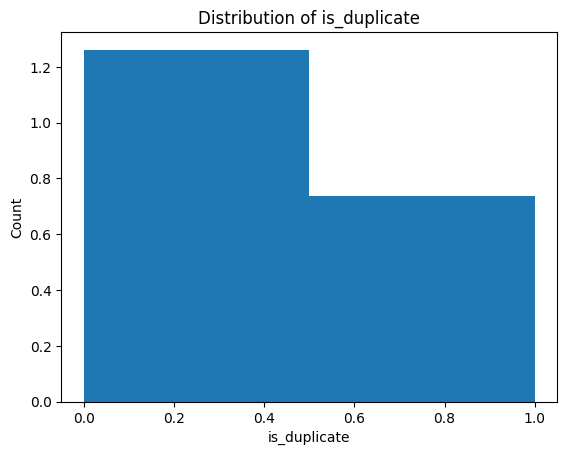

In [15]:
plt.hist(train_df["is_duplicate"], bins=2, density=True)
plt.xlabel("is_duplicate")
plt.ylabel("Count")
plt.title("Distribution of is_duplicate")
plt.show()

### Simple Similarity Check

In this section, we explore the simplest approach for question similarity detection. The idea is straightforward: we generate vectors for each sentence and compute the distance between these vectors. If the distance exceeds a certain decision boundary, we classify them as *different* questions; if it's below the threshold, we label them as *the same*.

While this method may not capture the full depth of semantic meaning—often generalizing too broadly—it can still be surprisingly effective for many datasets, especially when speed and simplicity are priorities.

For this implementation, I've utilized **Cosine Similarity** as the distance metric. However, other distance measures could yield comparably similar results with slight variations.

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# Initialize the model
encoder_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to encode sentences in batches
def batch_encode(sentences, batch_size=10000):
    iter = 0
    embeddings = []
    print(len(sentences))
    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i + batch_size]
        batch_embeddings = encoder_model.encode(batch, convert_to_tensor=True)
        embeddings.extend(batch_embeddings.cpu().numpy())
        iter += batch_size

        if iter % batch_size * 10 == 0:
            print((iter / len(sentences)) * 100)
    return np.array(embeddings)


In [ ]:
# Encode question1 and question2 in batches
question1_embedding = batch_encode(train_df["question1"].tolist())
question2_embedding = batch_encode(train_df["question2"].tolist())

In [18]:
train_df["question1_embedding"] = question1_embedding.tolist()

In [19]:
train_df["question2_embedding"] = question2_embedding.tolist()

In [ ]:
test_question1_embedding = batch_encode(test_df["question1"].tolist())
test_question2_embedding = batch_encode(test_df["question2"].tolist())

test_df["question1_embedding"] = test_question1_embedding.tolist()
test_df["question2_embedding"] = test_question2_embedding.tolist()

In [ ]:
i = 0
def cosine_similarity(vector1, vector2):
    global i
    i += 1
    if i % 100000 == 0:
        print(i)
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

train_df["similarity"] = train_df.apply(lambda row: cosine_similarity(row["question1_embedding"], row["question2_embedding"]), axis=1)

In [ ]:
test_df["similarity"] = test_df.apply(lambda row: cosine_similarity(row["question1_embedding"], row["question2_embedding"]), axis=1)

In [23]:
threshold = train_df[train_df["is_duplicate"] == 1]["similarity"].mean()
train_df["prediction"] = (train_df["similarity"] >= threshold).astype(int)
test_df["prediction"] = (test_df["similarity"] >= threshold).astype(int)

Train Accuracy: 0.7684437697299871
Train Precision: 0.7470093437201767
Train Recall: 0.5637383803701532
Train F1 Score: 0.6425612340352418
Train ROC AUC Score: 0.7259969429924131
Main Metric
Train Cross Entropy Loss: 8.346132503942945


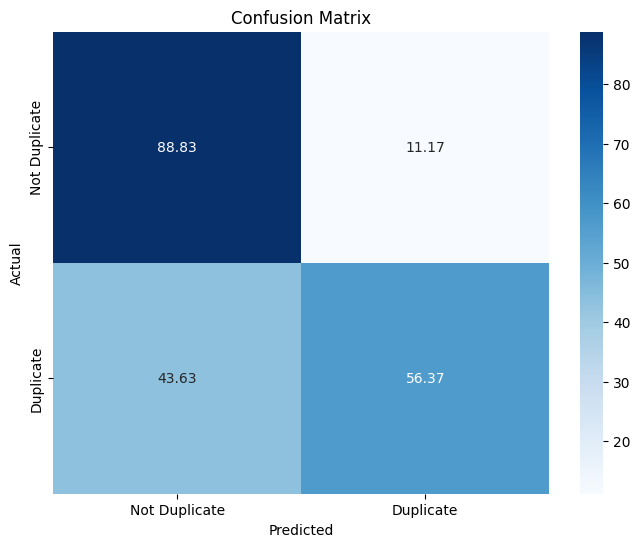

Test Accuracy: 0.7689777140171659
Test Precision: 0.7469607886477168
Test Recall: 0.5660067664891301
Test F1 Score: 0.6440141784502801
Test ROC AUC Score: 0.726891237376513
Main Metric
Test Cross Entropy Loss: 8.326887201126771


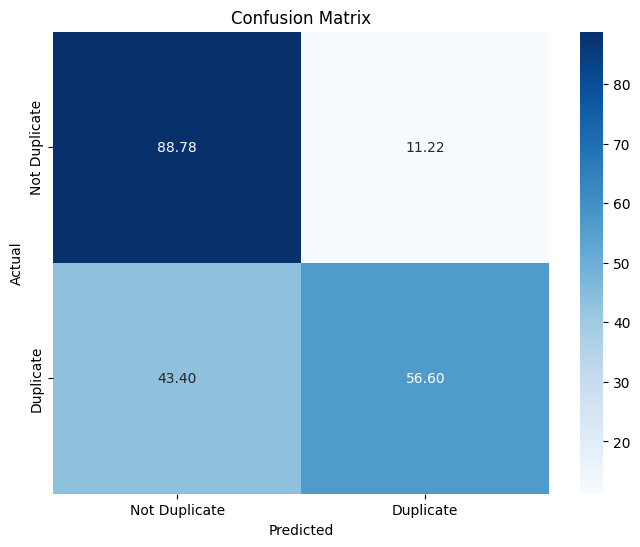

In [24]:
evaluate_model(train_df["is_duplicate"], train_df["prediction"], "Train")
evaluate_model(test_df["is_duplicate"], test_df["prediction"], "Test")

### XGBoost Model

In this section, we take a more sophisticated approach to question similarity detection using **XGBoost**, a powerful gradient boosting algorithm. Here, we provide the model with vectors for both questions as inputs, allowing it to analyze how each feature of these vectors relates to one another. The goal is for the model to learn patterns and relationships that distinguish between similar and different questions.

Because **gradient boosting models** excel at identifying non-linear patterns, this approach can significantly enhance our ability to differentiate between questions compared to simpler methods. The added complexity of XGBoost allows us to capture nuanced relationships in the data, resulting in more accurate classifications.

In [25]:
import xgboost as xgb

train_question1_embedding = np.array(train_df["question1_embedding"].tolist())
train_question2_embedding = np.array(train_df["question2_embedding"].tolist())
train_combined_embeddings = np.concatenate((question1_embedding, question2_embedding), axis=1)

test_question1_embedding = np.array(test_df["question1_embedding"].tolist())
test_question2_embedding = np.array(test_df["question2_embedding"].tolist())
test_combined_embeddings = np.concatenate((test_question1_embedding, test_question2_embedding), axis=1)

X_train = train_combined_embeddings
y_train = train_df["is_duplicate"]

X_test = test_combined_embeddings
y_test = test_df["is_duplicate"]

In [26]:
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'test')]

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'
params['eta'] = 0.02
params['max_depth'] = 4
params["device"] = "cuda"

bst = xgb.train(params, d_train, 9000, watchlist, early_stopping_rounds=50, verbose_eval=10)

[100]	train-auc:0.80427	test-auc:0.80019
[200]	train-auc:0.85486	test-auc:0.85057
[300]	train-auc:0.87453	test-auc:0.87015
[400]	train-auc:0.88543	test-auc:0.88097
[500]	train-auc:0.89257	test-auc:0.88767
[600]	train-auc:0.89788	test-auc:0.89256
[700]	train-auc:0.90207	test-auc:0.89630
[800]	train-auc:0.90559	test-auc:0.89936
[900]	train-auc:0.90860	test-auc:0.90191
[1000]	train-auc:0.91121	test-auc:0.90408
[1100]	train-auc:0.91351	test-auc:0.90596
[1200]	train-auc:0.91562	test-auc:0.90766
[1300]	train-auc:0.91754	test-auc:0.90916
[1400]	train-auc:0.91934	test-auc:0.91049
[1500]	train-auc:0.92106	test-auc:0.91179
[1600]	train-auc:0.92268	test-auc:0.91299
[1700]	train-auc:0.92419	test-auc:0.91408
[1800]	train-auc:0.92564	test-auc:0.91513
[1900]	train-auc:0.92702	test-auc:0.91611
[2000]	train-auc:0.92832	test-auc:0.91698
[2100]	train-auc:0.92954	test-auc:0.91780
[2200]	train-auc:0.93074	test-auc:0.91859
[2300]	train-auc:0.93187	test-auc:0.91937
[2400]	train-auc:0.93300	test-auc:0.92011
[

Train Accuracy: 0.9124908403389925
Train Precision: 0.871704487038261
Train Recall: 0.8946486893894984
Train F1 Score: 0.883027570331001
Train ROC AUC Score: 0.9087911688630865
Main Metric
Train Cross Entropy Loss: 3.1541498191942674


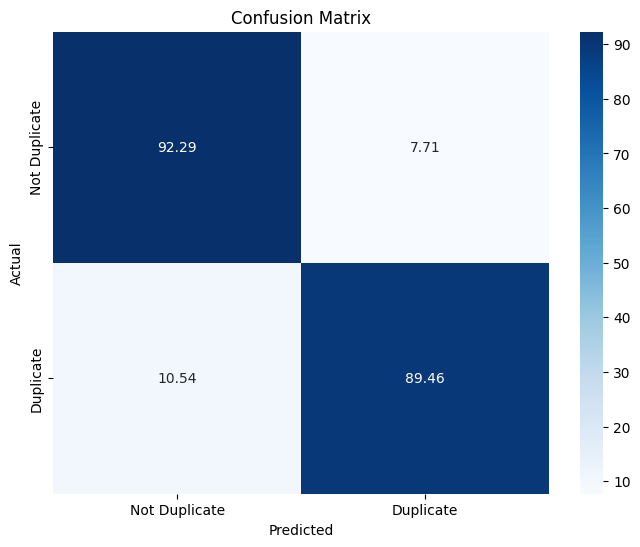

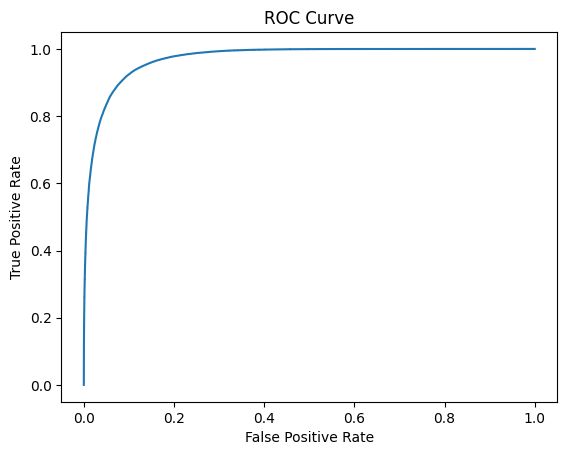

Test Accuracy: 0.864527937866383
Test Precision: 0.8080722459492061
Test Recall: 0.830268314742237
Test F1 Score: 0.8190199253213495
Test ROC AUC Score: 0.8574241289425331
Main Metric
Test Cross Entropy Loss: 4.882908051453032


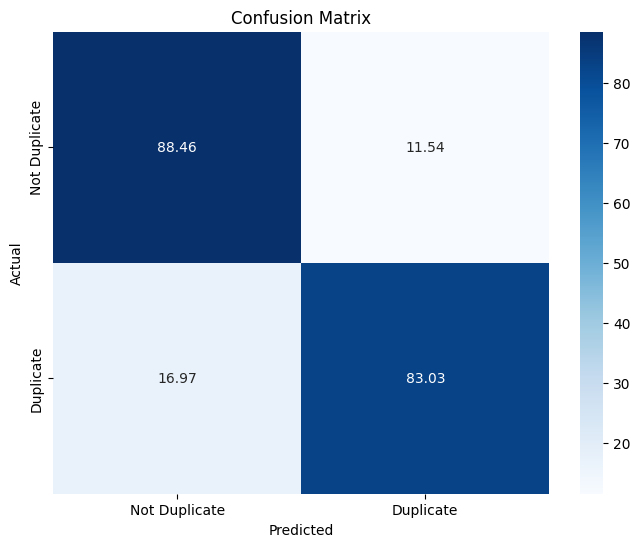

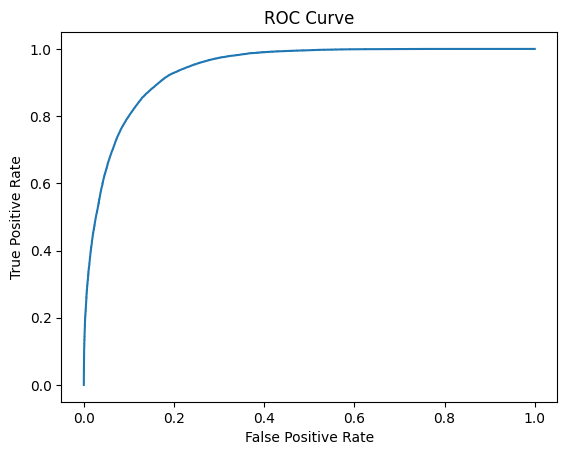

In [27]:
train_preds = bst.predict(d_train)
test_preds = bst.predict(d_test)

train_preds_label = (train_preds >= 0.5).astype(int)
test_preds_label = (test_preds >= 0.5).astype(int)

evaluate_model(y_train, train_preds_label, "Train")
plot_roc_curve(y_train, train_preds)
evaluate_model(y_test, test_preds_label, "Test")
plot_roc_curve(y_test, test_preds)


### BERT Fine-Tuning

In this section, we leverage the power of **BERT (Bidirectional Encoder Representations from Transformers)** to detect question similarity. BERT, a state-of-the-art transformer model, is pre-trained on a vast amount of text data to understand language contextually. By fine-tuning BERT on our specific dataset, we can tailor its deep contextual understanding to our task, enabling it to discern subtle semantic differences between questions.

For this approach, we feed the model pairs of questions and train it to classify whether they are the same or different. Unlike simpler models, BERT captures both the syntactic and semantic nuances of language, making it highly effective at identifying complex relationships between questions. Fine-tuning this model on our data allows us to harness its pre-trained knowledge while adapting it to our specific problem domain, resulting in significantly higher accuracy for challenging cases.

In [30]:
import pandas as pd
from datasets import Dataset

train_df['is_duplicate'] = train_df['is_duplicate'].astype(int)

# train_dataset_prep = train_df.drop(columns=["id", "qid1", "qid2", "question1_embedding", "question2_embedding", "similarity", "prediction"])
# test_dataset_prep = test_df.drop(columns=["id", "qid1", "qid2", "question1_embedding", "question2_embedding", "similarity", "prediction"])
train_dataset_prep = train_df.drop(columns=["id", "qid1", "qid2"])
test_dataset_prep = test_df.drop(columns=["id", "qid1", "qid2"])

concated_dataset_prep = pd.concat([train_dataset_prep, test_dataset_prep], ignore_index=True)

dataset = Dataset.from_pandas(concated_dataset_prep)
dataset = dataset.train_test_split(test_size=0.2)

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'question1_embedding', 'question2_embedding', 'similarity', 'prediction'],
        num_rows: 323429
    })
    test: Dataset({
        features: ['question1', 'question2', 'is_duplicate', 'question1_embedding', 'question2_embedding', 'similarity', 'prediction'],
        num_rows: 80858
    })
})

In [ ]:
from transformers import AutoTokenizer
import torch

model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Define a function to tokenize and prepare the dataset
def tokenize_function(examples):
    # Tokenize the sentences and include the 'labels' field
    tokenized = tokenizer(
        examples["question1"],
        examples["question2"],
        padding="max_length",
        truncation=True,
        max_length=128
    )
    tokenized["labels"] = examples["is_duplicate"]
    return tokenized

# Tokenize the dataset and include labels
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Ensure the labels are integers and in the correct format for PyTorch
tokenized_datasets = tokenized_datasets.map(lambda x: {"labels": torch.tensor(x["labels"], dtype=torch.long)})


In [33]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [34]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [35]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=400,
    per_device_eval_batch_size=400,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [36]:
print(tokenized_datasets["train"].features)

{'question1': Value(dtype='string', id=None), 'question2': Value(dtype='string', id=None), 'is_duplicate': Value(dtype='int64', id=None), 'question1_embedding': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'question2_embedding': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None), 'similarity': Value(dtype='float64', id=None), 'prediction': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Value(dtype='int64', id=None)}


In [37]:
trainer.train()

<IPython.core.display.Javascript object>

 ··········


Epoch,Training Loss,Validation Loss
1,0.291600,0.278788
2,0.234400,0.252123
3,0.205900,0.255199


TrainOutput(global_step=2427, training_loss=0.26118913677232863, metrics={'train_runtime': 4494.8268, 'train_samples_per_second': 215.867, 'train_steps_per_second': 0.54, 'total_flos': 6.382330914302208e+16, 'train_loss': 0.26118913677232863, 'epoch': 3.0})

In [38]:
trainer.save_model("fine_tuned_model")

Test Accuracy: 0.9186351381434119
Test Precision: 0.8663350752376755
Test Recall: 0.9218504002947777
Test F1 Score: 0.8932309839497558
Test ROC AUC Score: 0.919301829889571
Main Metric
Test Cross Entropy Loss: 2.93268687881226


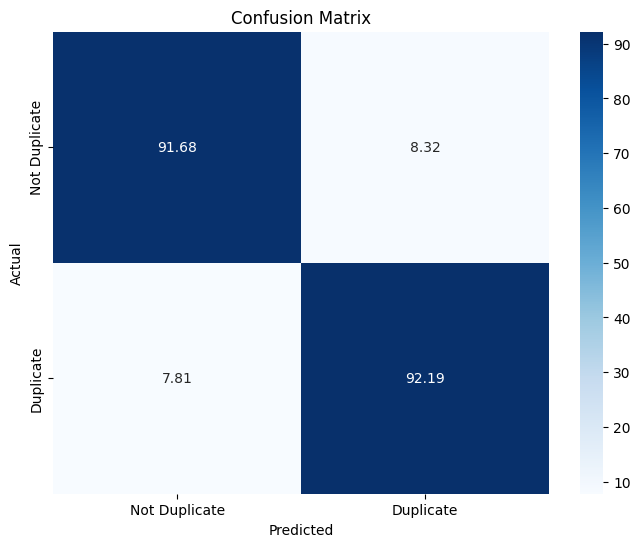

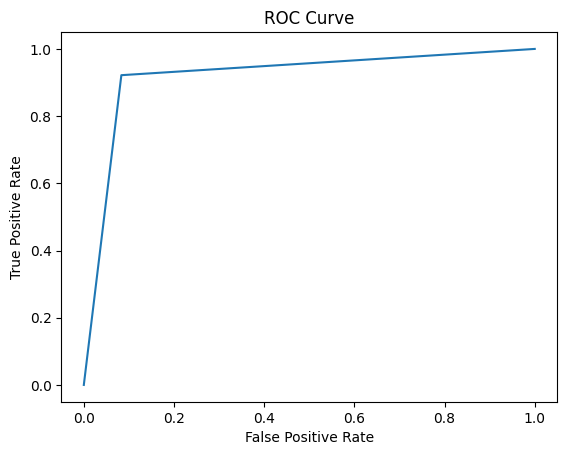

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

def evaluate(model, tokenizer, test_df, batch_size=1024):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []

    iter = 0

    for i in range(0, len(test_df), batch_size):
        iter += batch_size
        if iter % batch_size * 10 == 0:
            print((iter / len(test_df)) * 100)
        batch = test_df.iloc[i:i + batch_size]
        inputs = tokenizer(
            batch["question1"].tolist(),
            batch["question2"].tolist(),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        )
        inputs = {k: v.to('cuda') for k, v in inputs.items()} if torch.cuda.is_available() else inputs

        with torch.no_grad():
            outputs = model(**inputs)

        predictions = torch.argmax(outputs.logits, axis=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch["is_duplicate"].tolist())

    evaluate_model(all_labels, all_predictions, "Test")
    plot_roc_curve(all_labels, all_predictions)

# Usage
evaluate(model, tokenizer, test_df)
